#***1***. Visión general del proyecto

*   En este proyecto de predicción de churn se desarrolla un modelo de machine
learning capaz de anticipar qué clientes tienen mayor probabilidad de cancelar su suscripción. Reducir la tasa de churn es clave para maximizar los ingresos de la empresa y optimizar el gasto en adquisición de nuevos clientes. Aquí exploraremos los factores principales que impulsan la pérdida de usuarios y construiremos un clasificador robusto capaz de apoyar decisiones de retención.

#***2***. Descripción de los datos

Los datos provienen de un histórico de clientes en formato CSV e incluyen:



*   Demográficos: edad, género.
*   Métricas de uso: duración de la suscripción (meses), frecuencia de uso del servicio.
*   Facturación: importe mensual, número de pagos atrasados.
*   Atención al cliente: cantidad de tickets o incidencias abiertas, tiempo medio de respuesta.



La variable objetivo churn indica si el cliente canceló su servicio (1 = churn, 0 = retención).

#3. Metodología

El flujo de trabajo consta de cinco fases:



1.   Análisis exploratorio (EDA):


*   Inspección de valores faltantes.
*   Distribución de variables y desequilibrio de clases
*   Correlaciones y visualización de relaciones clave.


2.   Limpieza y preprocesamiento:


*   Imputación de valores nulos.
*   Codificación de variables categóricas con OneHotEncoder.
*   Escalado de variables numéricas con StandardScaler.


3. Ingeniería de características:


*  Creación de ratios (por ejemplo, tickets_soporte / antigüedad).

*  Flags binarios (por ejemplo, pagos_retrasados > 0).

*  Selección de las variables más informativas.


4. Modelado y ajuste:


*  Entrenamiento de varios clasificadores (Regresión Logística, Random Forest, Gradient Boosting y SVM).

*  Validación cruzada (5-fold) y búsqueda de hiperparámetros con GridSearchCV.

*  Manejo del desequilibrio con class_weight='balanced' o SMOTE.


5. Evaluación e interpretación:


*  Métricas: ROC-AUC, precisión, recall, F1 y matriz de confusión.

*  Curvas ROC y de precisión-recall.

*  Análisis de importancia de variables y explicaciones con SHAP.



#Librerias

In [ ]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

#Importar Dataset

In [ ]:

df =pd.read_csv("customer_churn_dataset-training-master.csv")
df

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.00,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.00,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.00,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.00,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.00,20.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
440828,449995.0,42.0,Male,54.0,15.0,1.0,3.0,Premium,Annual,716.38,8.0,0.0
440829,449996.0,25.0,Female,8.0,13.0,1.0,20.0,Premium,Annual,745.38,2.0,0.0
440830,449997.0,26.0,Male,35.0,27.0,1.0,5.0,Standard,Quarterly,977.31,9.0,0.0
440831,449998.0,28.0,Male,55.0,14.0,2.0,0.0,Standard,Quarterly,602.55,2.0,0.0


#Eliminar Costumer Id ya que no será de utilidad

In [ ]:

df = df.drop(columns = 'CustomerID')

In [ ]:
#Descripción del dataset

df.info()
df.describe()
df.isnull().sum()
df.columns



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Age                440832 non-null  float64
 1   Gender             440832 non-null  object 
 2   Tenure             440832 non-null  float64
 3   Usage Frequency    440832 non-null  float64
 4   Support Calls      440832 non-null  float64
 5   Payment Delay      440832 non-null  float64
 6   Subscription Type  440832 non-null  object 
 7   Contract Length    440832 non-null  object 
 8   Total Spend        440832 non-null  float64
 9   Last Interaction   440832 non-null  float64
 10  Churn              440832 non-null  float64
dtypes: float64(8), object(3)
memory usage: 37.0+ MB


Index(['Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls',
       'Payment Delay', 'Subscription Type', 'Contract Length', 'Total Spend',
       'Last Interaction', 'Churn'],
      dtype='object')

In [ ]:
#Verificar si hay valores nulos

df.isna().sum()

,0
Age,1
Gender,1
Tenure,1
Usage Frequency,1
Support Calls,1
Payment Delay,1
Subscription Type,1
Contract Length,1
Total Spend,1
Last Interaction,1


In [ ]:
#Identificar fila/s donde hayan valores nulos

df[df['Gender'].isna()]

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
199295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Eliminar fila donde hayan valores nulos

df = df.drop(199295)
df = df.reset_index(drop = True)
df

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.00,17.0,1.0
1,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.00,6.0,1.0
2,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.00,3.0,1.0
3,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.00,29.0,1.0
4,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.00,20.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
440827,42.0,Male,54.0,15.0,1.0,3.0,Premium,Annual,716.38,8.0,0.0
440828,25.0,Female,8.0,13.0,1.0,20.0,Premium,Annual,745.38,2.0,0.0
440829,26.0,Male,35.0,27.0,1.0,5.0,Standard,Quarterly,977.31,9.0,0.0
440830,28.0,Male,55.0,14.0,2.0,0.0,Standard,Quarterly,602.55,2.0,0.0


In [ ]:
#Verificar que ya no hayan valores nulos

df.isna().sum()

,0
Age,0
Gender,0
Tenure,0
Usage Frequency,0
Support Calls,0
Payment Delay,0
Subscription Type,0
Contract Length,0
Total Spend,0
Last Interaction,0


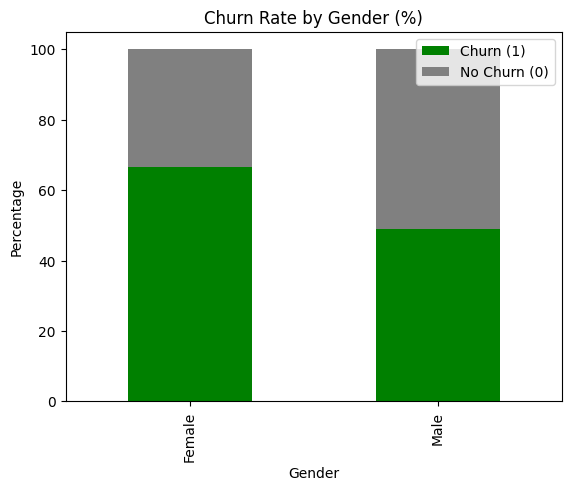

In [ ]:
#Churn vs gender


gender_churn = pd.crosstab(df['Gender'], df['Churn'], normalize='index') * 100


gender_churn = gender_churn[[1, 0]]


gender_churn.plot(kind='bar', stacked=True, color=['green', 'grey'])
plt.title("Churn Rate by Gender (%)")
plt.xlabel("Gender")
plt.ylabel("Percentage")
plt.legend(["Churn (1)", "No Churn (0)"], loc="upper right")
plt.show()


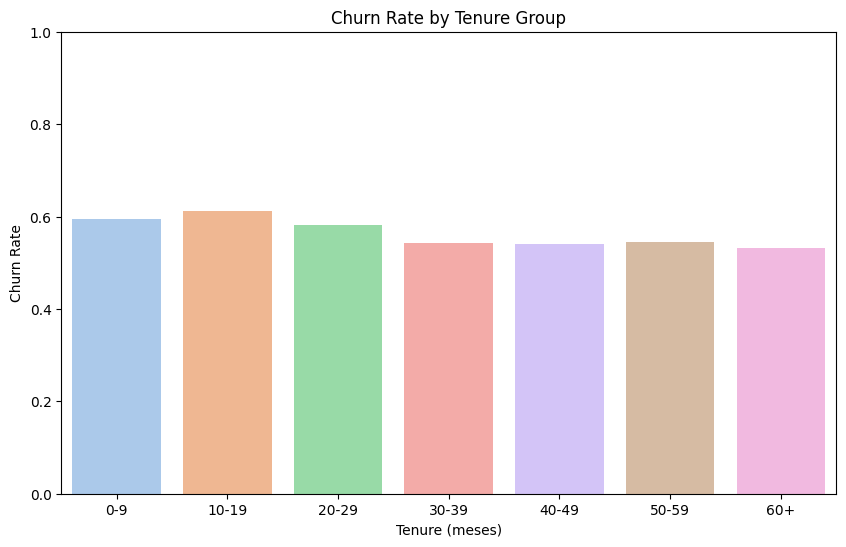

In [ ]:
#Churn vs Tenure

# 1. Definir los bins y las etiquetas
tenure_bins = [0, 10, 20, 30, 40, 50, 60, float('inf')]
tenure_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60+']

# 2. Crear la columna 'TenureGroup' a partir de los bins
df['TenureGroup'] = pd.cut(df['Tenure'], bins=tenure_bins, labels=tenure_labels, right=False)

# 3. Calcular la tasa de churn promedio por grupo de Tenure
tenure_churn_rate = df.groupby('TenureGroup')['Churn'].mean()

# 4. Graficar un barplot con la tasa de churn en cada grupo
plt.figure(figsize=(10, 6))
sns.barplot(x=tenure_churn_rate.index, y=tenure_churn_rate.values, palette='pastel')
plt.xlabel('Tenure (meses)')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Tenure Group')
plt.ylim(0, 1)  # Aseguramos que el eje Y vaya de 0 a 1
plt.show()


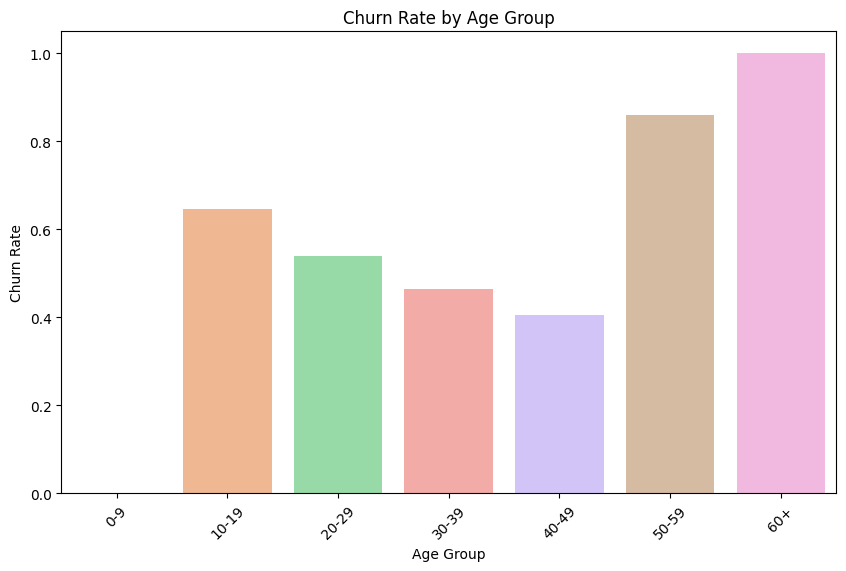

In [ ]:
#Churn vs Age Group


age_bins = [0, 10, 20, 30, 40, 50, 60, float('inf')]
age_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60+']
df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)


age_churn_rate = df.groupby('AgeGroup')['Churn'].mean()


plt.figure(figsize=(10, 6))
sns.barplot(x=age_churn_rate.index, y=age_churn_rate.values, palette='pastel')
plt.xlabel('Age Group')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Age Group')
plt.xticks(rotation=45)
plt.show()

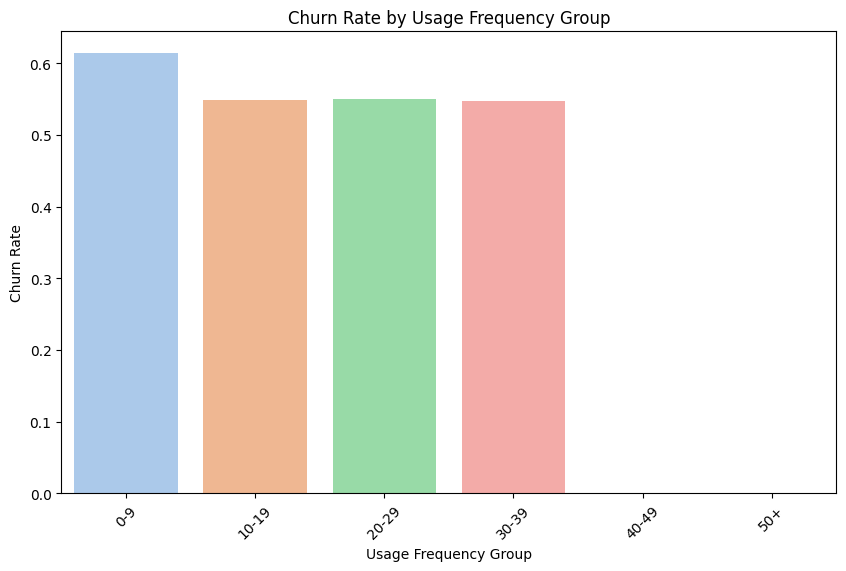

In [ ]:
#Churn vs Usage Frequency

usage_bins = [0, 10, 20, 30, 40, 50, float('inf')]
usage_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50+']
df['UsageGroup'] = pd.cut(df['Usage Frequency'], bins=usage_bins, labels=usage_labels, right=False)
usage_churn_rate = df.groupby('UsageGroup')['Churn'].mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=usage_churn_rate.index, y=usage_churn_rate.values, palette='pastel')
plt.xlabel('Usage Frequency Group')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Usage Frequency Group')
plt.xticks(rotation=45)
plt.show()


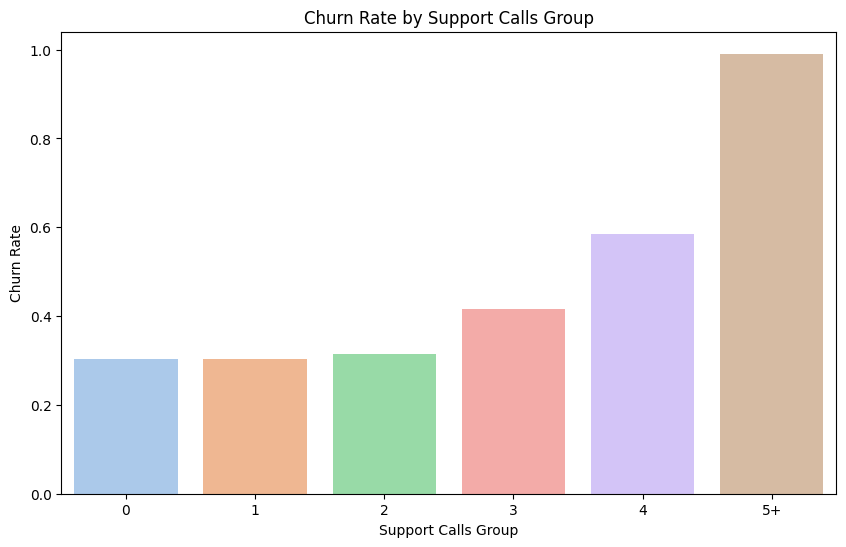

In [ ]:
#Churn vs Support Calls


support_bins = [0, 1, 2, 3, 4, 5, float('inf')]
support_labels = ['0', '1', '2', '3', '4', '5+']
df['SupportGroup'] = pd.cut(df['Support Calls'], bins=support_bins, labels=support_labels, right=False)
support_churn_rate = df.groupby('SupportGroup')['Churn'].mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=support_churn_rate.index, y=support_churn_rate.values, palette='pastel')
plt.xlabel('Support Calls Group')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Support Calls Group')
plt.show()

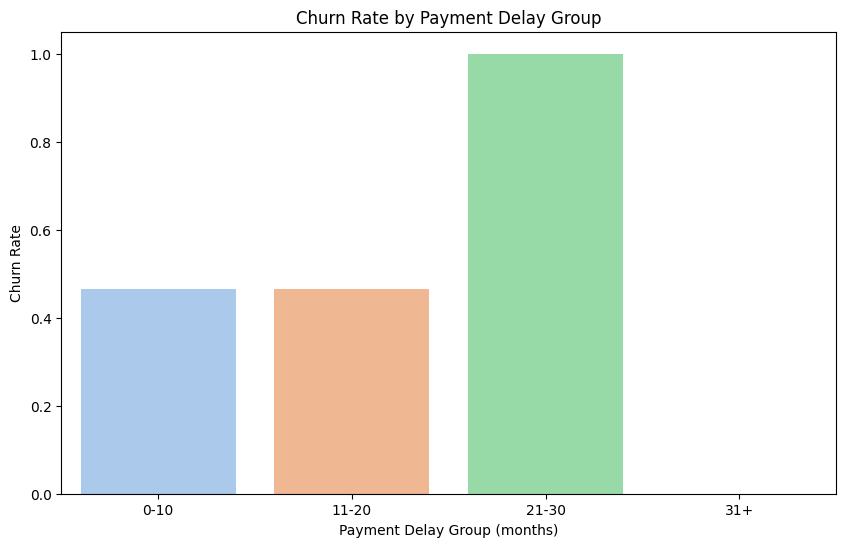

In [ ]:
#Churn vs Payment Delay


delay_bins = [0, 11, 21, 31, float('inf')]
delay_labels = ['0-10', '11-20', '21-30', '31+']
df['PaymentDelayGroup'] = pd.cut(df['Payment Delay'], bins=delay_bins, labels=delay_labels, right=False)


delay_churn_rate = df.groupby('PaymentDelayGroup')['Churn'].mean()


plt.figure(figsize=(10, 6))
sns.barplot(x=delay_churn_rate.index, y=delay_churn_rate.values, palette='pastel')
plt.xlabel('Payment Delay Group (months)')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Payment Delay Group')
plt.show()


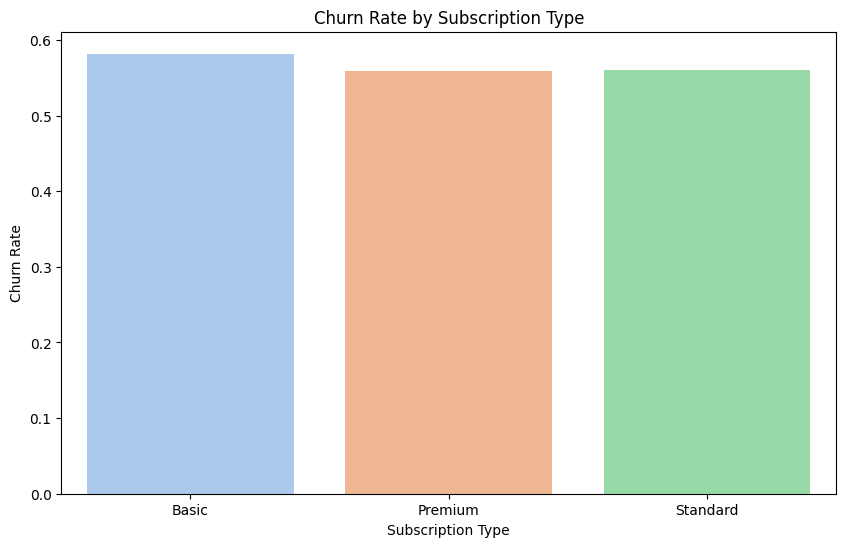

In [ ]:
#Churn vs Suscription Type

sub_churn_rate = df.groupby('Subscription Type')['Churn'].mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=sub_churn_rate.index, y=sub_churn_rate.values, palette='pastel')
plt.xlabel('Subscription Type')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Subscription Type')
plt.show()

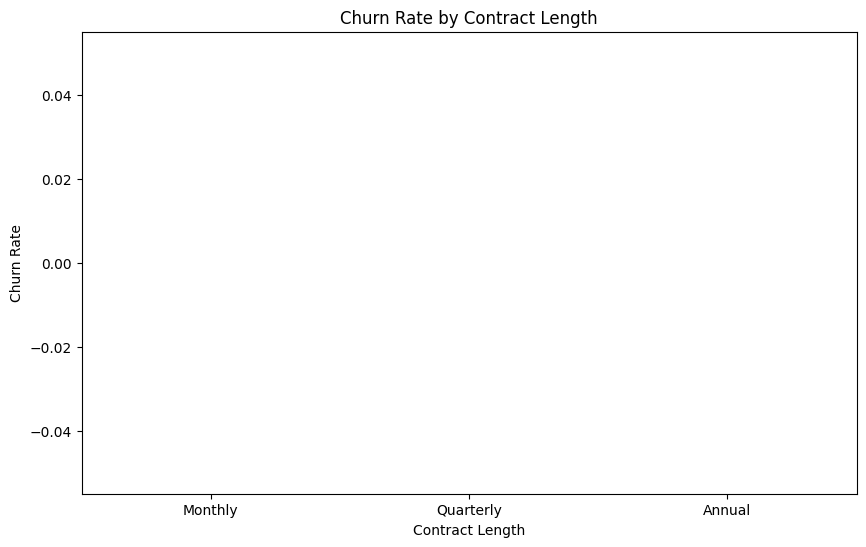

In [ ]:
#Churn vs Contract Lenght

# Definimos el orden deseado y un diccionario para transformar los valores numéricos a etiquetas
order = [1, 3, 12]  # Monthly=1, Quarterly=3, Annual=12
labels_map = {1: 'Monthly', 3: 'Quarterly', 12: 'Annual'}

# Calculamos la tasa de churn agrupando por 'Contract Length' y reordenando según 'order'
contract_churn_rate = df.groupby('Contract Length')['Churn'].mean().reindex(order)

plt.figure(figsize=(10, 6))
sns.barplot(x=[labels_map[val] for val in contract_churn_rate.index],
            y=contract_churn_rate.values, palette='pastel')
plt.xlabel('Contract Length')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Contract Length')
plt.show()

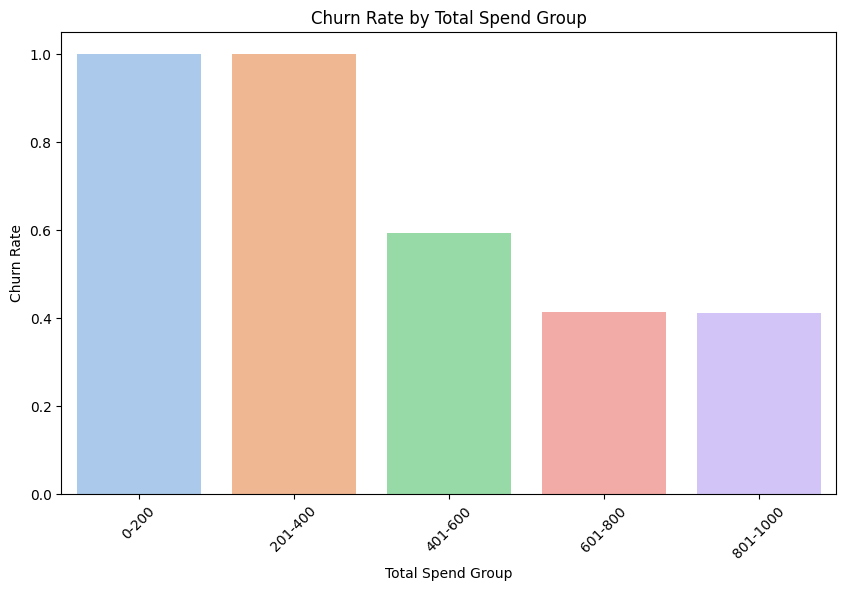

In [ ]:

#Churn vs Total Spend

spend_bins = [0, 201, 401, 601, 801, 1001]
spend_labels = ['0-200', '201-400', '401-600', '601-800', '801-1000']


df['TotalSpendGroup'] = pd.cut(df['Total Spend'], bins=spend_bins, labels=spend_labels, right=False)


spend_churn_rate = df.groupby('TotalSpendGroup')['Churn'].mean()


plt.figure(figsize=(10, 6))
sns.barplot(x=spend_churn_rate.index, y=spend_churn_rate.values, palette='pastel')
plt.xlabel('Total Spend Group')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Total Spend Group')
plt.xticks(rotation=45)
plt.show()


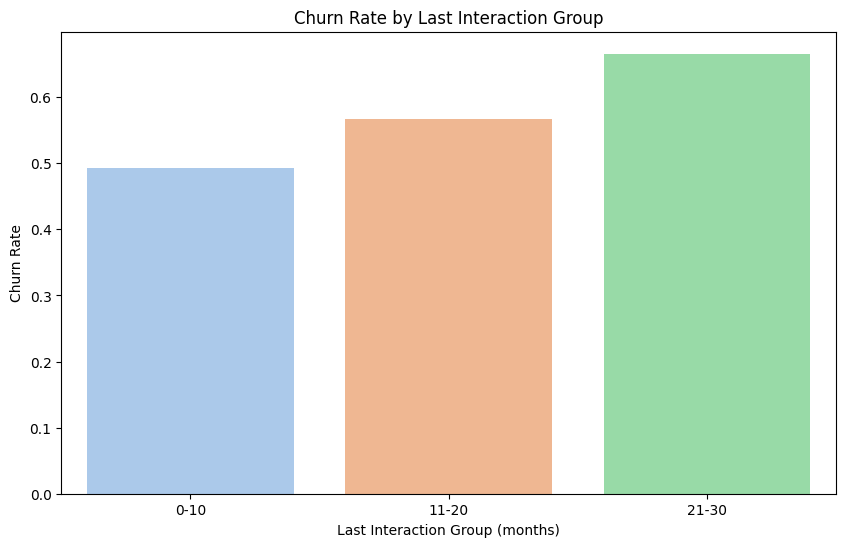

In [ ]:
#Churn vs Last Interaction

interaction_bins = [0, 11, 21, 31]
interaction_labels = ['0-10', '11-20', '21-30']
df['LastInteractionGroup'] = pd.cut(df['Last Interaction'], bins=interaction_bins, labels=interaction_labels, right=False)


interaction_churn_rate = df.groupby('LastInteractionGroup')['Churn'].mean()


plt.figure(figsize=(10, 6))
sns.barplot(x=interaction_churn_rate.index, y=interaction_churn_rate.values, palette='pastel')
plt.xlabel('Last Interaction Group (months)')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Last Interaction Group')
plt.show()


In [ ]:
# Aplicar MinMaxScaling a la variable ''Age''

scaler = MinMaxScaler()
df['Age_scaled'] = scaler.fit_transform(df[['Age']])


print(df[['Age', 'Age_scaled']].head())

    Age  Age_scaled
0  30.0    0.255319
1  65.0    1.000000
2  55.0    0.787234
3  58.0    0.851064
4  23.0    0.106383


In [ ]:
# Definir Female = 0 y Male = 1

gender_map = {'Female': 0, 'Male': 1}
df['Gender_scaled'] = df['Gender'].map(gender_map)

df['Gender_scaled'].fillna(df['Gender_scaled'].mode()[0], inplace=True)


In [ ]:
print(df['Gender'])

0         Female
1         Female
2         Female
3           Male
4           Male
           ...  
440827      Male
440828    Female
440829      Male
440830      Male
440831      Male
Name: Gender, Length: 440832, dtype: object


In [ ]:
# Aplicar MinMaxScaling a la variable ''Tenure''

scaler = MinMaxScaler()
df['Tenure_scaled'] = scaler.fit_transform(df[['Tenure']])


print(df[['Tenure', 'Tenure_scaled']].head())

   Tenure  Tenure_scaled
0    39.0       0.644068
1    49.0       0.813559
2    14.0       0.220339
3    38.0       0.627119
4    32.0       0.525424


In [ ]:
# Aplicar MinMaxScaling a la variable ''Usage Frequency''

scaler = MinMaxScaler()
df['Usage_Frequency_scaled'] = scaler.fit_transform(df[['Usage Frequency']])


print(df[['Usage Frequency', 'Usage_Frequency_scaled']].head())

   Usage Frequency  Usage_Frequency_scaled
0             14.0                0.448276
1              1.0                0.000000
2              4.0                0.103448
3             21.0                0.689655
4             20.0                0.655172


In [ ]:
# Aplicar MinMaxScaling a la variable ''Support Calls''

scaler = MinMaxScaler()
df['Support_Calls_scaled'] = scaler.fit_transform(df[['Support Calls']])
print(df[['Support Calls', 'Support_Calls_scaled']].head())

   Support Calls  Support_Calls_scaled
0            5.0                   0.5
1           10.0                   1.0
2            6.0                   0.6
3            7.0                   0.7
4            5.0                   0.5


In [ ]:
# Aplicar MinMaxScaling a la variable ''Payment Delay''

scaler = MinMaxScaler()
df['Payment_Delay_scaled'] = scaler.fit_transform(df[['Payment Delay']])
print(df[['Payment Delay', 'Payment_Delay_scaled']].head())

   Payment Delay  Payment_Delay_scaled
0           18.0              0.600000
1            8.0              0.266667
2           18.0              0.600000
3            7.0              0.233333
4            8.0              0.266667


In [ ]:
# Aplicar Label Encoder a la variable ''Suscription_type''

subscription_map = {'Basic': 0, 'Standard': 1, 'Premium': 2}
df['Subscription Type'] = df['Subscription Type'].map(subscription_map)
print(df[['Subscription Type']].head())

   Subscription Type
0                  1
1                  0
2                  0
3                  1
4                  0


In [ ]:
# Aplicar Label Encoder a la variable ''Contract_Lenght''

contract_map = {'Monthly': 1, 'Quarterly': 3, 'Annual': 12}
df['Contract Length'] = df['Contract Length'].map(contract_map)


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['Contract_Length_scaled'] = scaler.fit_transform(df[['Contract Length']])


print(df[['Contract Length', 'Contract_Length_scaled']].head())

   Contract Length  Contract_Length_scaled
0               12                1.000000
1                1                0.000000
2                3                0.181818
3                1                0.000000
4                1                0.000000


In [ ]:
# Aplicar MinMaxScaling a la variable ''Total Spend''

scaler = MinMaxScaler()
df['Total_Spend_scaled'] = scaler.fit_transform(df[['Total Spend']])
print(df[['Total Spend', 'Total_Spend_scaled']].head())

   Total Spend  Total_Spend_scaled
0        932.0            0.924444
1        557.0            0.507778
2        185.0            0.094444
3        396.0            0.328889
4        617.0            0.574444


In [ ]:
# Aplicar MinMaxScaling a la variable ''Last Interaction''

scaler = MinMaxScaler()
df['Last_Interaction_scaled'] = scaler.fit_transform(df[['Last Interaction']])
print(df[['Last Interaction', 'Last_Interaction_scaled']].head())

   Last Interaction  Last_Interaction_scaled
0              17.0                 0.551724
1               6.0                 0.172414
2               3.0                 0.068966
3              29.0                 0.965517
4              20.0                 0.655172


In [ ]:
#Ingenieria Inversa entre Tenure y Total Spend para obtener el gasto mensual por cliente


df['Tenure_safe'] = df['Tenure'].replace(0, np.nan)

df['Monthly_Spend'] = df['Total Spend'] / df['Tenure_safe']


scaler = MinMaxScaler()
df['Monthly_Spend_scaled'] = scaler.fit_transform(df[['Monthly_Spend']])


print(df[['Total Spend', 'Tenure', 'Monthly_Spend_scaled']].head())

   Total Spend  Tenure  Monthly_Spend_scaled
0        932.0    39.0              0.022268
1        557.0    49.0              0.009717
2        185.0    14.0              0.011567
3        396.0    38.0              0.008769
4        617.0    32.0              0.017644


In [ ]:
print(df.head(10))

    Age  Gender  Tenure  Usage Frequency  Support Calls  Payment Delay  \
0  30.0  Female    39.0             14.0            5.0           18.0   
1  65.0  Female    49.0              1.0           10.0            8.0   
2  55.0  Female    14.0              4.0            6.0           18.0   
3  58.0    Male    38.0             21.0            7.0            7.0   
4  23.0    Male    32.0             20.0            5.0            8.0   
5  51.0    Male    33.0             25.0            9.0           26.0   
6  58.0  Female    49.0             12.0            3.0           16.0   
7  55.0  Female    37.0              8.0            4.0           15.0   
8  39.0    Male    12.0              5.0            7.0            4.0   
9  64.0  Female     3.0             25.0            2.0           11.0   

   Subscription Type  Contract Length  Total Spend  Last Interaction  ...  \
0                  1               12        932.0              17.0  ...   
1                  0           

In [ ]:
#Variables que se van a utilizar en los modelos


features = [
    'Age_scaled',
   # 'Tenure_scaled',
   # 'Usage_Frequency_scaled',
    'Support_Calls_scaled',
    'Payment_Delay_scaled',
    'Total_Spend_scaled',
    'Last_Interaction_scaled',
    'Gender_scaled',
   # 'Subscription Type',
    'Contract_Length_scaled',
    'Monthly_Spend_scaled'
]

X = df[features]
Y = df['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

In [ ]:
# 3. Modelo 1: SGDClassifier

sgd_model = SGDClassifier(loss='log_loss', alpha=0.001, random_state=42, max_iter=5000)
sgd_model.fit(X_train, Y_train)


Y_pred_sgd = sgd_model.predict(X_test)
print("SGDClassifier Accuracy (default threshold):", accuracy_score(Y_test, Y_pred_sgd))
print("SGDClassifier Classification Report (default threshold):")
print(classification_report(Y_test, Y_pred_sgd))



probs_sgd = sgd_model.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0, 1, 101)
cost_fp = 1
cost_fn = 3
costs = []

for thresh in thresholds:
    preds = (probs_sgd >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(Y_test, preds).ravel()
    cost = fp * cost_fp + fn * cost_fn
    costs.append(cost)

optimal_threshold = thresholds[np.argmin(costs)]
print("Optimal threshold based on cost matrix:", optimal_threshold)

optimal_preds = (probs_sgd >= optimal_threshold).astype(int)
print("SGDClassifier Accuracy (optimal threshold):", accuracy_score(Y_test, optimal_preds))
print("SGDClassifier Classification Report (optimal threshold):")
print(classification_report(Y_test, optimal_preds))



SGDClassifier Accuracy (default threshold): 0.8570553608492973
SGDClassifier Classification Report (default threshold):
              precision    recall  f1-score   support

         0.0       0.82      0.85      0.84     38167
         1.0       0.88      0.86      0.87     50000

    accuracy                           0.86     88167
   macro avg       0.85      0.86      0.85     88167
weighted avg       0.86      0.86      0.86     88167

Optimal threshold based on cost matrix: 0.3
SGDClassifier Accuracy (optimal threshold): 0.8166774416731883
SGDClassifier Classification Report (optimal threshold):
              precision    recall  f1-score   support

         0.0       0.89      0.66      0.76     38167
         1.0       0.78      0.94      0.85     50000

    accuracy                           0.82     88167
   macro avg       0.84      0.80      0.80     88167
weighted avg       0.83      0.82      0.81     88167



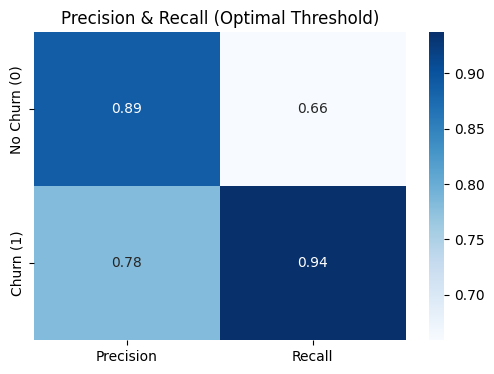

In [ ]:

#Matriz de decisión

precision_opt, recall_opt, fscore_opt, support_opt = precision_recall_fscore_support(Y_test, optimal_preds, average=None)


metrics_opt = pd.DataFrame({
    'Precision': precision_opt,
    'Recall': recall_opt,
    'F1 Score': fscore_opt,
    'Support': support_opt
}, index=['No Churn (0)', 'Churn (1)'])



metrics_subset = metrics_opt[['Precision', 'Recall']]

plt.figure(figsize=(6, 4))
sns.heatmap(metrics_subset, annot=True, cmap="Blues", fmt=".2f")
plt.title("Precision & Recall (Optimal Threshold)")
plt.show()

In [ ]:
# 4. Modelo 2: KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

# Seleccionamos k=5
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, Y_train)

Y_pred_knn = knn_model.predict(X_test)
print("KNeighborsClassifier Accuracy:", accuracy_score(Y_test, Y_pred_knn))
print("KNeighborsClassifier Classification Report:")
print(classification_report(Y_test, Y_pred_knn))

KNeighborsClassifier Accuracy: 0.9778261707895244
KNeighborsClassifier Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98     38167
         1.0       1.00      0.96      0.98     50000

    accuracy                           0.98     88167
   macro avg       0.98      0.98      0.98     88167
weighted avg       0.98      0.98      0.98     88167



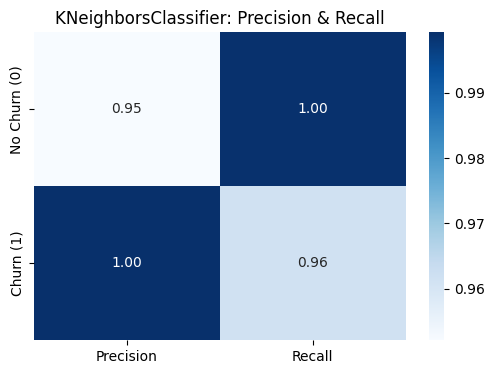

In [ ]:

#Matriz de decisión

precision_knn, recall_knn, _, _ = precision_recall_fscore_support(Y_test, Y_pred_knn, average=None)

metrics_knn = pd.DataFrame({
    'Precision': precision_knn,
    'Recall': recall_knn
}, index=['No Churn (0)', 'Churn (1)'])


plt.figure(figsize=(6, 4))
sns.heatmap(metrics_knn, annot=True, cmap="Blues", fmt=".2f")
plt.title("KNeighborsClassifier: Precision & Recall")
plt.show()